In [1]:
import os

# Dataset root path
data_dir = '/kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'

# List to store all file paths
all_files = []

# Walk through every folder and subfolder
for root, dirs, files in os.walk(data_dir):
    for f in files:
        file_path = os.path.join(root, f)
        all_files.append(file_path)

# Show total number of files
print(f"✅ Total files found: {len(all_files)}")

# Show a few sample file paths
print("\n📂 Example file paths:")
for i, path in enumerate(all_files[:15]):
    print(f"{i+1}. {path}")

# Optional: summary by folder (robust version)
folder_summary = {}
for f in all_files:
    relative_path = os.path.dirname(f).replace(data_dir, '').strip(os.sep)
    parts = relative_path.split(os.sep)
    folder = parts[0] if len(parts) > 0 and parts[0] != '' else "root"
    folder_summary[folder] = folder_summary.get(folder, 0) + 1

print("\n📊 File count by top-level folder:")
for k, v in folder_summary.items():
    print(f"{k:20s} : {v}")

✅ Total files found: 87204

📂 Example file paths:
1. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/SHA256SUMS.txt
2. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/RECORDS
3. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/example_physionet.py
4. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_v103_changelog.txt
5. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/scp_statements.csv
6. /kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3/ptbxl_database.csv
7. /kaggle/input/a-large-publicly-available-electro

In [2]:
!pip install wfdb -q

import os, ast, wfdb
import numpy as np
import pandas as pd
from tqdm import tqdm

# ---- CONFIG ----
PATH = '/kaggle/input/a-large-publicly-available-electrocardiography/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.3'
SAMPLING_RATE = 100  # 100 or 500 depending on which files you use
EXPECTED_SECONDS = 10  # PTB-XL is 10s normally
EXPECTED_LEN = SAMPLING_RATE * EXPECTED_SECONDS
FILE_COL = 'filename_lr' if SAMPLING_RATE == 100 else 'filename_hr'

# ---- 1) Read metadata and parse scp_codes safely ----
meta = pd.read_csv(os.path.join(PATH, 'ptbxl_database.csv'), index_col='ecg_id')
def safe_parse_scpcodes(s):
    try:
        return ast.literal_eval(s) if pd.notna(s) else {}
    except Exception:
        return {}
meta['scp_codes'] = meta['scp_codes'].apply(safe_parse_scpcodes)

# ---- 2) Load diagnostic mapping and keep only diagnostic statements ----
agg_df = pd.read_csv(os.path.join(PATH, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df['diagnostic'] == 1]

def aggregate_diagnostic(y_dic):
    out = []
    for k in y_dic.keys():
        if k in agg_df.index:
            out.append(agg_df.loc[k, 'diagnostic_class'])
    return list(set(out))

meta['diagnostic_superclass'] = meta['scp_codes'].apply(aggregate_diagnostic)

# ---- 3) Keep only single-label ECGs (and reset index for easy iteration) ----
mask = meta['diagnostic_superclass'].apply(lambda x: len(x) == 1)
meta_filtered = meta[mask].copy()
# simplify to single string label
meta_filtered['diagnostic_superclass'] = meta_filtered['diagnostic_superclass'].apply(lambda x: x[0])
meta_filtered = meta_filtered.reset_index()  # optional, makes iterating easier

print("Filtered metadata samples:", len(meta_filtered))
print(meta_filtered['diagnostic_superclass'].value_counts())

# ---- 4) Load signals for *only* filtered metadata rows ----
def load_signal_safe(record_name, records_dir):
    """
    Try to load record_name using wfdb.rdsamp. Returns a 2D numpy array (T, n_leads) or None on error.
    record_name should match what's in the metadata FILE_COL (commonly record name without extension).
    """
    try:
        # wfdb accepts a path-like string; if your csv already has directory or extensions, try both approaches
        sig, fields = wfdb.rdsamp(os.path.join(records_dir, record_name))
        # sig is shape (n_samples, n_leads) as numpy array
        return sig
    except Exception:
        # try fallback: maybe csv contains full filename with extension, try removing extension or using record_name only
        base = os.path.splitext(record_name)[0]
        try:
            sig, fields = wfdb.rdsamp(os.path.join(records_dir, base))
            return sig
        except Exception as e:
            print("Could not load:", record_name, "error:", str(e))
            return None

signals = []
labels = []
failed = []
for _, row in tqdm(meta_filtered.iterrows(), total=len(meta_filtered)):
    rec_name = row[FILE_COL]
    sig = load_signal_safe(rec_name, PATH)
    if sig is None:
        failed.append(rec_name)
        continue

    # Ensure shape consistency: (n_samples, n_leads)
    # Convert dtype and pad/truncate to EXPECTED_LEN
    sig = np.asarray(sig, dtype=np.float32)
    n_samples, n_leads = sig.shape
    if n_samples < EXPECTED_LEN:
        # pad at end with zeros
        pad_len = EXPECTED_LEN - n_samples
        sig = np.pad(sig, ((0, pad_len),(0,0)), mode='constant')
    elif n_samples > EXPECTED_LEN:
        sig = sig[:EXPECTED_LEN, :]

    # Convert to (T, C) -> eventually we may want (C, T) for PyTorch, but keep (T, C) now
    signals.append(sig)
    labels.append(row['diagnostic_superclass'])

print("Loaded signals:", len(signals), "Failed:", len(failed))

# Convert to numpy arrays
# signals shape -> (N, T, C)
X_filtered = np.stack(signals).astype(np.float32)
y_filtered = pd.Series(labels)

print("X_filtered shape:", X_filtered.shape)  # (n_samples, n_timesteps, n_leads)
print("y_filtered shape:", y_filtered.shape)

# Optional: save for caching to disk so you don't re-read WFDB next time
# np.save('X_filtered.npy', X_filtered)
# y_filtered.to_csv('Y_filtered.csv', index=False)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.1 MB/s eta 0:00:00
Filtered metadata samples: 16244
diagnostic_superclass
NORM    9069
MI      2532
STTC    2400
CD      1708
HYP      535
Name: count, dtype: int64


100%|██████████| 16244/16244 [02:03<00:00, 131.21it/s]


Loaded signals: 16244 Failed: 0
X_filtered shape: (16244, 1000, 12)
y_filtered shape: (16244,)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def conv_1x1_bn(in_ch, out_ch):
    return nn.Sequential(nn.Conv1d(in_ch, out_ch, 1, 1, 0, bias=False),
                         nn.BatchNorm1d(out_ch),
                         nn.ReLU6(inplace=True))

def conv_bn(in_ch, out_ch, k, s, p):
    return nn.Sequential(nn.Conv1d(in_ch, out_ch, k, stride=s, padding=p, bias=False),
                         nn.BatchNorm1d(out_ch),
                         nn.ReLU6(inplace=True))

class InvertedResidual1D(nn.Module):
    def __init__(self, inp, oup, stride, expand_ratio):
        super().__init__()
        hidden_dim = int(round(inp * expand_ratio))
        self.use_res_connect = (stride == 1 and inp == oup)
        layers = []
        if expand_ratio != 1:
            layers.append(conv_1x1_bn(inp, hidden_dim))
        layers.extend([
            nn.Conv1d(hidden_dim, hidden_dim, kernel_size=3, stride=stride, padding=1, groups=hidden_dim, bias=False),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU6(inplace=True),
            nn.Conv1d(hidden_dim, oup, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm1d(oup),
        ])
        self.conv = nn.Sequential(*layers)

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

class MobileNetV2_1D(nn.Module):
    def __init__(self, in_channels=12, num_classes=5, width_mult=1.0):
        super().__init__()
        # setting of inverted residual blocks: t, c, n, s
        # t: expand_ratio, c: output channels, n: repeats, s: stride (first block)
        settings = [
            (1, 16, 1, 1),
            (6, 24, 2, 2),
            (6, 32, 3, 2),
            (6, 64, 4, 2),
            (6, 96, 3, 1),
            (6, 160, 3, 2),
            (6, 320, 1, 1),
        ]
        input_channel = int(32 * width_mult)
        layers = [conv_bn(in_channels, input_channel, k=3, s=2, p=1)]
        for t, c, n, s in settings:
            output_channel = int(c * width_mult)
            for i in range(n):
                stride = s if i == 0 else 1
                layers.append(InvertedResidual1D(input_channel, output_channel, stride, expand_ratio=t))
                input_channel = output_channel
        last_channel = int(1280 * max(1.0, width_mult))
        layers.append(conv_1x1_bn(input_channel, last_channel))
        self.features = nn.Sequential(*layers)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.classifier = nn.Sequential(nn.Dropout(0.2), nn.Linear(last_channel, num_classes))

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x).squeeze(-1)
        x = self.classifier(x)
        return x

def build_mobilenetv2_1d(in_channels, num_classes, width_mult=1.0):
    return MobileNetV2_1D(in_channels=in_channels, num_classes=num_classes, width_mult=width_mult)

In [4]:
# ---------------- Augmentation cell (paste this BEFORE Block B) ----------------
# Defines 1D signal augmentations, AugmentedDataset, and mixup helper.
# Usage: replace your train dataset creation with:
#   train_ds = AugmentedDataset(X_train, y_train, augment=True, aug_probs=None, seed=SEED)
# Keep validation/test datasets unchanged (no augmentation).

import numpy as np
import torch
from torch.utils.data import Dataset

# ---------- simple augmentations (operate on numpy arrays shaped (C, T)) ----------
def jitter(x, sigma=0.01):
    """Add Gaussian noise to entire sample (C,T)."""
    return x + np.random.normal(0, sigma, size=x.shape).astype(x.dtype)

def scaling(x, sigma=0.1):
    """Scale each channel by a factor ~ N(1, sigma)."""
    factors = np.random.normal(1.0, sigma, size=(x.shape[0], 1)).astype(x.dtype)
    return (x * factors)

def channel_dropout(x, p=0.1):
    """Zero out full channels with probability p (per sample)."""
    mask = (np.random.rand(x.shape[0]) > p).astype(x.dtype)
    return x * mask[:, None]

def random_crop_or_pad(x, crop_frac_min=0.85, crop_frac_max=1.0):
    """Randomly crop a contiguous segment and pad back to original length (keeps T constant)."""
    C, T = x.shape
    crop_frac = np.random.uniform(crop_frac_min, crop_frac_max)
    new_T = max(1, int(T * crop_frac))
    if new_T == T:
        return x
    start = np.random.randint(0, T - new_T + 1)
    cropped = x[:, start:start+new_T]
    out = np.zeros_like(x)
    if np.random.rand() < 0.5:
        out[:, :new_T] = cropped
    else:
        pos = np.random.randint(0, T - new_T + 1)
        out[:, pos:pos+new_T] = cropped
    return out

def random_shift(x, shift_max_frac=0.05):
    """Shift along time axis (zero-pad) by up to +/- shift_max_frac * T."""
    C, T = x.shape
    max_shift = int(shift_max_frac * T)
    if max_shift <= 0:
        return x
    shift = np.random.randint(-max_shift, max_shift+1)
    if shift == 0:
        return x
    out = np.zeros_like(x)
    if shift > 0:
        out[:, shift:] = x[:, :-shift]
    else:
        out[:, :shift] = x[:, -shift:]
    return out

def time_mask(x, max_mask_frac=0.1):
    """Zero a random contiguous time window up to max_mask_frac of T."""
    C, T = x.shape
    mask_len = int(np.random.uniform(0.0, max_mask_frac) * T)
    if mask_len <= 0:
        return x
    start = np.random.randint(0, T - mask_len + 1)
    x_copy = x.copy()
    x_copy[:, start:start+mask_len] = 0
    return x_copy

# ---------- optional mixup for training loop ----------
def mixup_data(x, y, alpha=0.2):
    """
    Mixup inputs and targets.
    x: torch tensor (B,C,T), y: torch tensor (B,)
    returns: mixed_x, y_a, y_b, lam
    """
    if alpha <= 0:
        return x, y, y, 1.0
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, ...]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# ---------- AugmentedDataset ----------
class AugmentedDataset(Dataset):
    """
    X: numpy array (N, C, T)
    y: array-like (N,)
    augment: bool
    aug_probs: dict with per-transform probabilities (keys: 'jitter','scaling','chan_drop','crop','shift','time_mask')
    seed: int or None for deterministic RNG per worker (useful for reproducibility)
    """
    def __init__(self, X, y, augment=True, aug_probs=None, seed=None):
        self.X = X
        self.y = np.array(y)
        self.augment = bool(augment)
        self.seed = seed
        # RNG: use RandomState to make dataset deterministic if seed provided
        self.rng = np.random.RandomState(seed) if seed is not None else np.random
        defaults = {
            'jitter': 0.5,
            'scaling': 0.5,
            'chan_drop': 0.3,
            'crop': 0.3,
            'shift': 0.3,
            'time_mask': 0.3
        }
        if aug_probs is None:
            aug_probs = defaults
        else:
            # fill missing keys
            for k,v in defaults.items():
                aug_probs.setdefault(k, v)
        self.aug_probs = aug_probs

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx].copy()   # numpy (C,T)
        y = int(self.y[idx])
        if self.augment:
            # use self.rng for reproducibility when seed provided
            if self.rng.rand() < self.aug_probs.get('jitter', 0):
                x = jitter(x, sigma=0.02)
            if self.rng.rand() < self.aug_probs.get('scaling', 0):
                x = scaling(x, sigma=0.1)
            if self.rng.rand() < self.aug_probs.get('chan_drop', 0):
                x = channel_dropout(x, p=0.2)
            if self.rng.rand() < self.aug_probs.get('crop', 0):
                x = random_crop_or_pad(x, crop_frac_min=0.85, crop_frac_max=1.0)
            if self.rng.rand() < self.aug_probs.get('shift', 0):
                x = random_shift(x, shift_max_frac=0.05)
            if self.rng.rand() < self.aug_probs.get('time_mask', 0):
                x = time_mask(x, max_mask_frac=0.08)
        return torch.from_numpy(x.astype(np.float32)), torch.tensor(y, dtype=torch.long)

# ---------- example usage (comment out if not needed) ----------
# Assuming you will run Block B after this cell and that SEED is defined:
# train_ds = AugmentedDataset(X_train, y_train, augment=True, aug_probs=None, seed=SEED)
# val_ds   = AugmentedDataset(X_val, y_val, augment=False)    # or keep SimpleSignalDataset for val/test
# test_ds  = AugmentedDataset(X_test, y_test, augment=False)
# If using mixup: inside your train_one_epoch, call mixup_data(Xb, yb, alpha=0.2) before forwarding.


In [5]:
# ------------------ Block B (MobileNetV2-1D, augmented, dropout head, sampler, optional mixup)
# with epoch-level plots: loss, acc, and ROC AUC ------------------
import numpy as np
import pandas as pd
import torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy, os, random, math

# ---------------- config ----------------
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

OUT_DIR = "split_results"
os.makedirs(OUT_DIR, exist_ok=True)

# Hyperparams (tune to your GPU)
BATCH_SIZE = 256
LR = 1e-4
WEIGHT_DECAY = 1e-6
EPOCHS = 50
SPLITS = [0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90]
VAL_FRAC_FROM_TRAIN = 0.10

# Head / dropout
DROPOUT_P = 0.5
HEAD_HIDDEN = 512

# DataLoader performance
NUM_WORKERS = 4
PIN_MEMORY = True if torch.cuda.is_available() else False

# Mixup toggle
MIXUP_ALPHA = 0.2  # set 0 to disable

# Safety checks: expects MobileNetV2 builder & AugmentedDataset defined in prior cells
if 'X_filtered' not in globals() or 'y_filtered' not in globals():
    raise RuntimeError("X_filtered and y_filtered must be defined. Run the augmentation cell + data loading first.")
if 'build_mobilenetv2_1d' not in globals():
    raise RuntimeError("build_mobilenetv2_1d not found. Paste the MobileNetV2-1D implementation into Block A first.")

# ---------------- prepare labels / data ----------------
le = LabelEncoder()
y_array = le.fit_transform(np.array(y_filtered))
class_names = list(le.classes_)
n_classes = len(class_names)
print("Classes:", class_names)

# Convert X to (N, C, T)
X = X_filtered.transpose(0,2,1).astype(np.float32)
y = y_array

# ---------------- Dataset classes ----------------
class SimpleSignalDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = np.array(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx].astype(np.float32)), torch.tensor(int(self.y[idx]), dtype=torch.long)

# ---------------- training / evaluation helpers (updated for metrics) ----------------
def train_one_epoch(model, loader, optimizer, mixup_alpha=0.0):
    model.train()
    total_loss = 0.0
    all_preds = []
    all_trues = []
    for Xb, yb in loader:
        Xb, yb = Xb.to(DEVICE).float(), yb.to(DEVICE)
        optimizer.zero_grad()
        if mixup_alpha and mixup_alpha > 0:
            Xb, y_a, y_b, lam = mixup_data(Xb, yb, alpha=mixup_alpha)
            logits = model(Xb)
            loss = lam * F.cross_entropy(logits, y_a) + (1.0 - lam) * F.cross_entropy(logits, y_b)
            preds = logits.detach().argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_trues.append(yb.detach().cpu().numpy())
        else:
            logits = model(Xb)
            loss = F.cross_entropy(logits, yb)
            preds = logits.detach().argmax(dim=1).cpu().numpy()
            all_preds.append(preds)
            all_trues.append(yb.detach().cpu().numpy())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    avg_loss = total_loss / len(loader.dataset)
    if all_preds:
        all_preds = np.concatenate(all_preds)
        all_trues = np.concatenate(all_trues)
        train_acc = float((all_preds == all_trues).mean())
    else:
        train_acc = None
    return avg_loss, train_acc

def evaluate(model, loader):
    model.eval()
    total_loss = 0.0
    preds = []
    probs = []
    trues = []
    with torch.no_grad():
        for Xb, yb in loader:
            Xb, yb = Xb.to(DEVICE).float(), yb.to(DEVICE)
            logits = model(Xb)
            loss = F.cross_entropy(logits, yb)
            total_loss += loss.item() * Xb.size(0)
            prob = torch.softmax(logits, dim=1).cpu().numpy()
            p = prob.argmax(axis=1)
            preds.append(p)
            probs.append(prob)
            trues.append(yb.cpu().numpy())
    preds = np.concatenate(preds) if preds else np.array([])
    probs = np.concatenate(probs) if probs else np.array([[]])
    trues = np.concatenate(trues) if trues else np.array([])
    avg_loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else float('nan')
    acc = float((preds == trues).mean()) if len(trues) > 0 else None
    return avg_loss, preds, probs, trues, acc

def add_dropout_head(model, in_features=None, n_classes=None, hidden=HEAD_HIDDEN, p=DROPOUT_P):
    # works whether model.fc or model.classifier exists (MobileNetV2 uses .classifier)
    if n_classes is None:
        raise ValueError("n_classes must be provided")
    detected = None
    if in_features is None:
        if hasattr(model, "fc") and isinstance(model.fc, nn.Linear):
            detected = model.fc.in_features
        elif hasattr(model, "classifier"):
            cls = model.classifier
            if isinstance(cls, nn.Linear):
                detected = cls.in_features
            elif isinstance(cls, nn.Sequential):
                for module in cls:
                    if isinstance(module, nn.Linear):
                        detected = module.in_features
                        break
    if in_features is None and detected is None:
        raise RuntimeError("Could not detect in_features automatically. Please pass in_features explicitly.")
    in_features = in_features or detected

    new_head = nn.Sequential(
        nn.Dropout(p=p),
        nn.Linear(in_features, hidden),
        nn.ReLU(inplace=True),
        nn.Dropout(p=p),
        nn.Linear(hidden, n_classes)
    )
    if hasattr(model, "fc"):
        model.fc = new_head
    elif hasattr(model, "classifier"):
        model.classifier = new_head
    else:
        model.classifier = new_head
    return model

def train_full_epochs(model, train_loader, val_loader, split_name,
                      epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, mixup_alpha=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
    best_val_loss = 1e9
    best_state = copy.deepcopy(model.state_dict())

    history = {
        'epoch': [],
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': [],
        'val_macro_auc': []
    }

    for ep in range(1, epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, mixup_alpha=mixup_alpha)
        val_loss, _, val_probs, val_trues, val_acc = evaluate(model, val_loader)

        try:
            if len(val_trues) > 0:
                present = np.unique(val_trues)
                if len(present) >= 2:
                    y_true_bin = label_binarize(val_trues, classes=np.arange(n_classes))
                    val_macro_auc = float(roc_auc_score(y_true_bin, val_probs, average='macro', multi_class='ovr'))
                else:
                    val_macro_auc = float('nan')
            else:
                val_macro_auc = float('nan')
        except Exception:
            val_macro_auc = float('nan')

        scheduler.step(val_loss)
        print(f"Epoch {ep:02d}/{epochs:02d} -> train_loss={tr_loss:.4f} val_loss={val_loss:.4f} "
              f"train_acc={tr_acc:.4f} val_acc={val_acc:.4f} val_macro_auc={np.nan if math.isnan(val_macro_auc) else val_macro_auc:.4f}")

        history['epoch'].append(ep)
        history['train_loss'].append(tr_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(tr_acc)
        history['val_acc'].append(val_acc)
        history['val_macro_auc'].append(val_macro_auc)

        if val_loss < best_val_loss - 1e-8:
            best_val_loss = val_loss
            best_state = copy.deepcopy(model.state_dict())
            torch.save(best_state, os.path.join(OUT_DIR, f"best_model_{split_name}.pth"))

    model.load_state_dict(best_state)
    return model, history

def plot_and_save_roc(y_true, y_score, classes, out_path):
    try:
        y_true_binarized = label_binarize(y_true, classes=np.arange(len(classes)))
    except Exception:
        return
    n_classes_local = y_score.shape[1]
    plt.figure(figsize=(8,6))
    lw = 2
    for i in range(n_classes_local):
        if np.sum(y_true_binarized[:, i]) == 0:
            continue
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=lw, label=f'{classes[i]} (AUC = {roc_auc:.3f})')
    try:
        fpr_micro, tpr_micro, _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
        auc_micro = auc(fpr_micro, tpr_micro)
        plt.plot(fpr_micro, tpr_micro, linestyle='--', label=f'Micro-average (AUC={auc_micro:.3f})')
    except Exception:
        pass
    plt.plot([0,1],[0,1],'k--', lw=1)
    plt.xlim([0.0,1.0]); plt.ylim([0.0,1.05])
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right', fontsize='small')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(out_path, dpi=150)
    plt.close()

# ---------------- main loop over splits (with plotting) ----------------
summary_rows = []
for test_size in SPLITS:
    print("\n" + "="*60)
    train_ratio_percent = int((1-test_size)*100)
    split_name = f"{train_ratio_percent}-{int(test_size*100)}"
    print("Running split:", split_name)

    try:
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED, stratify=y)
    except Exception:
        X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED, stratify=None)

    try:
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=VAL_FRAC_FROM_TRAIN, random_state=SEED, stratify=y_train_full)
    except Exception:
        X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=VAL_FRAC_FROM_TRAIN, random_state=SEED, stratify=None)

    print(f"Sizes -> train: {len(X_train)} val: {len(X_val)} test: {len(X_test)}")

    # datasets
    train_ds = AugmentedDataset(X_train, y_train, augment=True, aug_probs=None, seed=SEED)
    val_ds   = SimpleSignalDataset(X_val, y_val)
    test_ds  = SimpleSignalDataset(X_test, y_test)

    # sampler for imbalance
    try:
        class_counts = np.bincount(y_train)
        inv_freq = 1.0 / (class_counts + 1e-6)
        sample_weights = inv_freq[y_train]
        sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, sampler=sampler, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    except Exception:
        train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    # build MobileNetV2-1D model + optional dropout head
    model = build_mobilenetv2_1d(in_channels=X.shape[1], num_classes=n_classes, width_mult=0.75)
    # replace final classifier with dropout head for stronger regularization (autodetect)
    try:
        model = add_dropout_head(model, in_features=None, n_classes=n_classes, hidden=HEAD_HIDDEN, p=DROPOUT_P)
    except Exception as e:
        print("Auto-detect head failed:", e)
        # try to detect fc/classifier linear in typical attribute names
        if hasattr(model, "fc") and isinstance(model.fc, nn.Linear):
            in_feats = model.fc.in_features
        elif hasattr(model, "classifier") and isinstance(model.classifier, nn.Linear):
            in_feats = model.classifier.in_features
        elif hasattr(model, "classifier") and isinstance(model.classifier, nn.Sequential):
            # find first Linear in classifier
            in_feats = None
            for m in model.classifier:
                if isinstance(m, nn.Linear):
                    in_feats = m.in_features
                    break
            if in_feats is None:
                in_feats = 512
        else:
            in_feats = 512
        model = add_dropout_head(model, in_features=in_feats, n_classes=n_classes, hidden=HEAD_HIDDEN, p=DROPOUT_P)

    model = model.to(DEVICE)
    trainable_count = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Model params -> trainable: {trainable_count:,}")

    # train and get history
    model, history = train_full_epochs(model, train_loader, val_loader, split_name=split_name,
                                      epochs=EPOCHS, lr=LR, weight_decay=WEIGHT_DECAY, mixup_alpha=MIXUP_ALPHA)

    # save history CSV
    hist_df = pd.DataFrame(history)
    hist_csv = os.path.join(OUT_DIR, f"history_{split_name}.csv")
    hist_df.to_csv(hist_csv, index=False)
    print("Saved training history to", hist_csv)

    # plot loss curve
    plt.figure(figsize=(7,5))
    plt.plot(history['epoch'], history['train_loss'], label='train_loss')
    plt.plot(history['epoch'], history['val_loss'], label='val_loss')
    plt.xlabel('epoch'); plt.ylabel('loss'); plt.title(f'Loss - {split_name}')
    plt.legend(); plt.grid(True); plt.tight_layout()
    loss_png = os.path.join(OUT_DIR, f"loss_curve_{split_name}.png")
    plt.savefig(loss_png, dpi=150); plt.close()
    print("Saved loss curve to", loss_png)

    # plot accuracy curve
    plt.figure(figsize=(7,5))
    plt.plot(history['epoch'], history['train_acc'], label='train_acc')
    plt.plot(history['epoch'], history['val_acc'], label='val_acc')
    plt.xlabel('epoch'); plt.ylabel('accuracy'); plt.title(f'Accuracy - {split_name}')
    plt.legend(); plt.grid(True); plt.tight_layout()
    acc_png = os.path.join(OUT_DIR, f"acc_curve_{split_name}.png")
    plt.savefig(acc_png, dpi=150); plt.close()
    print("Saved accuracy curve to", acc_png)

    # plot val ROC AUC curve (macro)
    plt.figure(figsize=(7,5))
    val_aucs = [np.nan if (v is None) else (np.nan if math.isnan(v) else v) for v in history['val_macro_auc']]
    plt.plot(history['epoch'], val_aucs, marker='o', label='val_macro_auc')
    plt.xlabel('epoch'); plt.ylabel('macro ROC AUC'); plt.title(f'Validation Macro AUC - {split_name}')
    plt.ylim(0.0, 1.05); plt.grid(True); plt.legend(); plt.tight_layout()
    roc_auc_png = os.path.join(OUT_DIR, f"roc_auc_curve_{split_name}.png")
    plt.savefig(roc_auc_png, dpi=150); plt.close()
    print("Saved ROC AUC curve to", roc_auc_png)

    # --- evaluate on test set and per-class report/roc ---
    test_loss, preds, probs, trues, test_acc = evaluate(model, test_loader)
    cls_report = classification_report(trues, preds, target_names=class_names, output_dict=True, zero_division=0)
    cls_report_df = pd.DataFrame(cls_report).transpose()
    cls_report_df.to_csv(os.path.join(OUT_DIR, f"classification_report_{split_name}.csv"))
    print("\nClassification report for split", split_name)
    print(cls_report_df)

    # compute per-class AUC and macro AUC on test set
    try:
        per_class_auc = {}
        present_classes = []
        for i, cname in enumerate(class_names):
            if np.sum(trues == i) > 0:
                y_true_bin = (trues == i).astype(int)
                try:
                    this_auc = roc_auc_score(y_true_bin, probs[:, i])
                except Exception:
                    this_auc = np.nan
                per_class_auc[cname] = float(this_auc) if not np.isnan(this_auc) else None
                present_classes.append(i)
            else:
                per_class_auc[cname] = None

        if len(present_classes) >= 2:
            y_true_bin_all = label_binarize(trues, classes=np.arange(n_classes))
            macro_auc = roc_auc_score(y_true_bin_all, probs, average='macro', multi_class='ovr')
        else:
            macro_auc = None
    except Exception as e:
        print("ROC AUC computation issue:", e)
        per_class_auc = {c: None for c in class_names}
        macro_auc = None

    # save ROC curve figure for test set
    roc_path = os.path.join(OUT_DIR, f"roc_curves_{split_name}.png")
    try:
        plot_and_save_roc(trues, probs, class_names, roc_path)
    except Exception as e:
        print("Could not plot ROC:", e)

    # save final model state for this split
    torch.save(model.state_dict(), os.path.join(OUT_DIR, f"model_final_{split_name}.pth"))

    # append summary
    summary_rows.append({
        'split': split_name,
        'train_size': len(X_train),
        'val_size': len(X_val),
        'test_size': len(X_test),
        'test_loss': float(test_loss),
        'test_acc': float(test_acc) if test_acc is not None else None,
        'macro_auc': float(macro_auc) if macro_auc is not None else None,
        'per_class_auc': per_class_auc
    })

# Save summary CSV
summary_df = pd.DataFrame(summary_rows)
summary_df.to_csv(os.path.join(OUT_DIR, "summary_splits_overview.csv"), index=False)
print("\nSaved results to", OUT_DIR)
print(summary_df)


Classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']

Running split: 90-10
Sizes -> train: 13157 val: 1462 test: 1625
Model params -> trainable: 1,973,509
Epoch 01/50 -> train_loss=1.5433 val_loss=1.3194 train_acc=0.2421 val_acc=0.5657 val_macro_auc=0.6862
Epoch 02/50 -> train_loss=1.4572 val_loss=1.4256 train_acc=0.2995 val_acc=0.4029 val_macro_auc=0.7476
Epoch 03/50 -> train_loss=1.3865 val_loss=1.3214 train_acc=0.3449 val_acc=0.4535 val_macro_auc=0.7756
Epoch 04/50 -> train_loss=1.3275 val_loss=1.2663 train_acc=0.3233 val_acc=0.4815 val_macro_auc=0.7945
Epoch 05/50 -> train_loss=1.2866 val_loss=1.1552 train_acc=0.3588 val_acc=0.5534 val_macro_auc=0.8161
Epoch 06/50 -> train_loss=1.2704 val_loss=1.2664 train_acc=0.3102 val_acc=0.4843 val_macro_auc=0.8172
Epoch 07/50 -> train_loss=1.2097 val_loss=1.2919 train_acc=0.3486 val_acc=0.4829 val_macro_auc=0.8170
Epoch 08/50 -> train_loss=1.2206 val_loss=1.1712 train_acc=0.3426 val_acc=0.5198 val_macro_auc=0.8403
Epoch 09/50 -> train_loss=1.1760 val_


=== 19-80 (50 epochs) ===


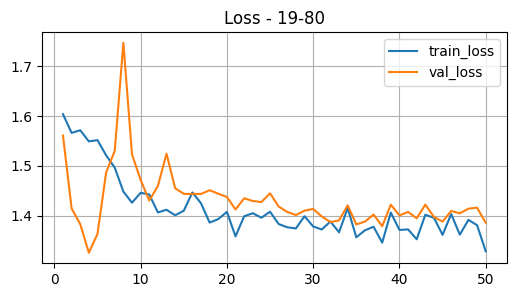

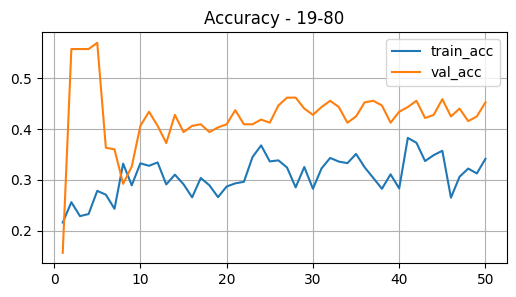

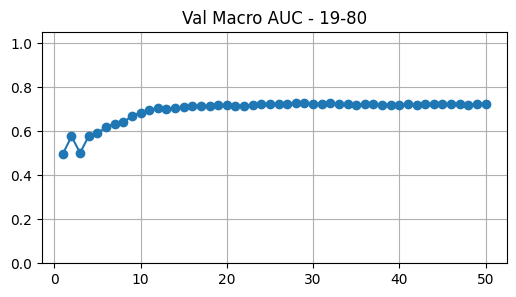

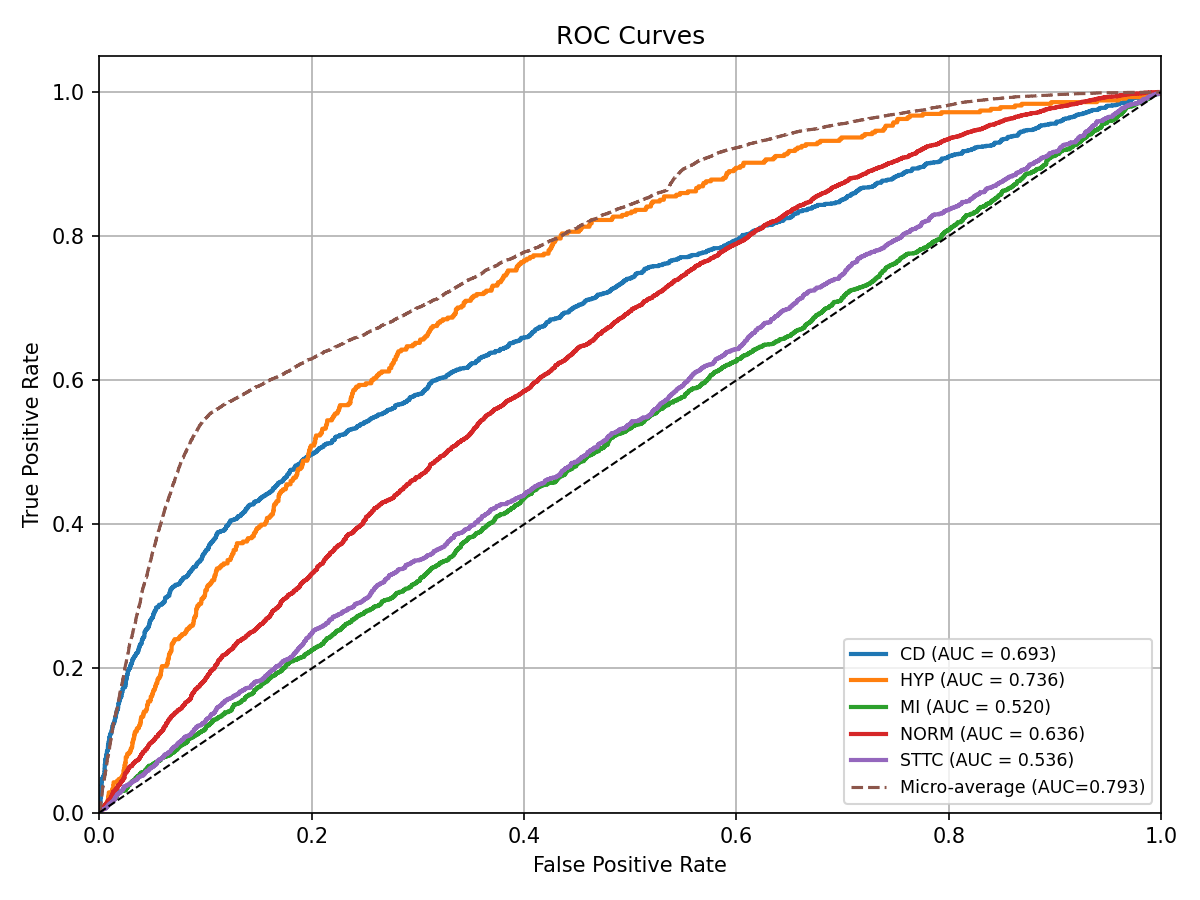


=== 30-70 (50 epochs) ===


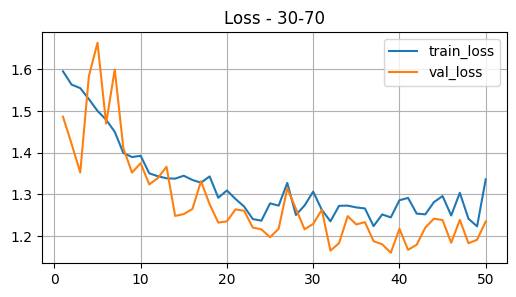

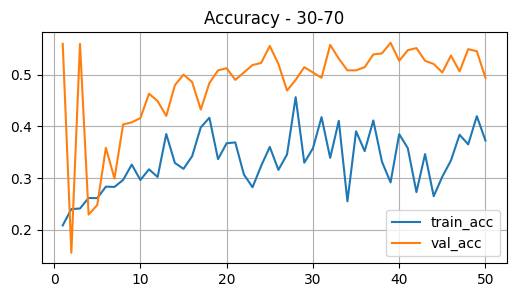

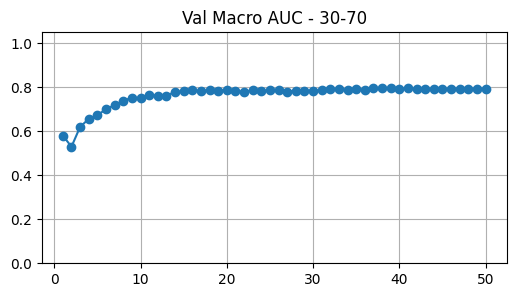

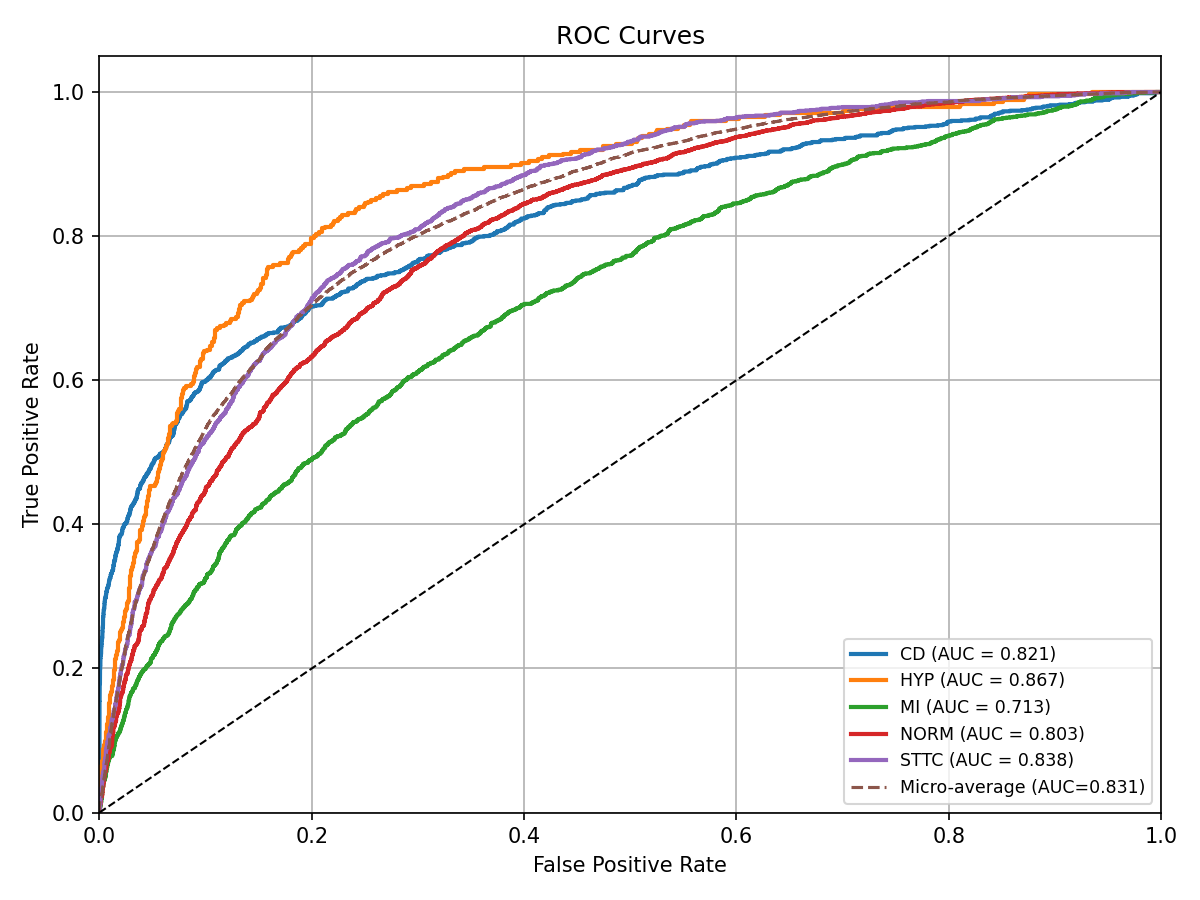


=== 40-60 (50 epochs) ===


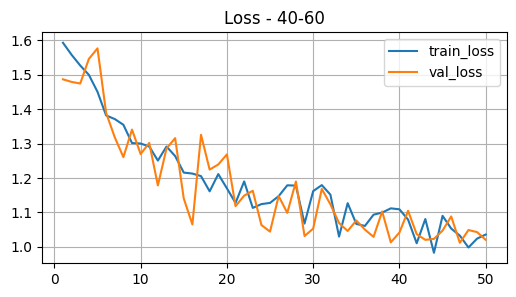

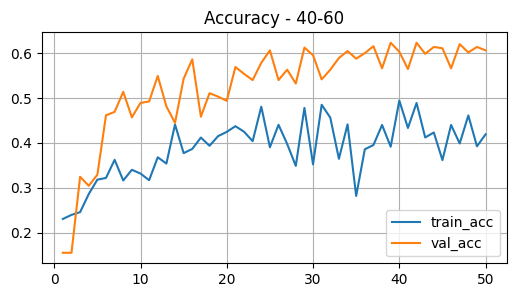

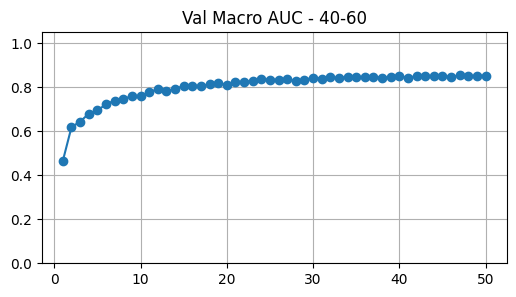

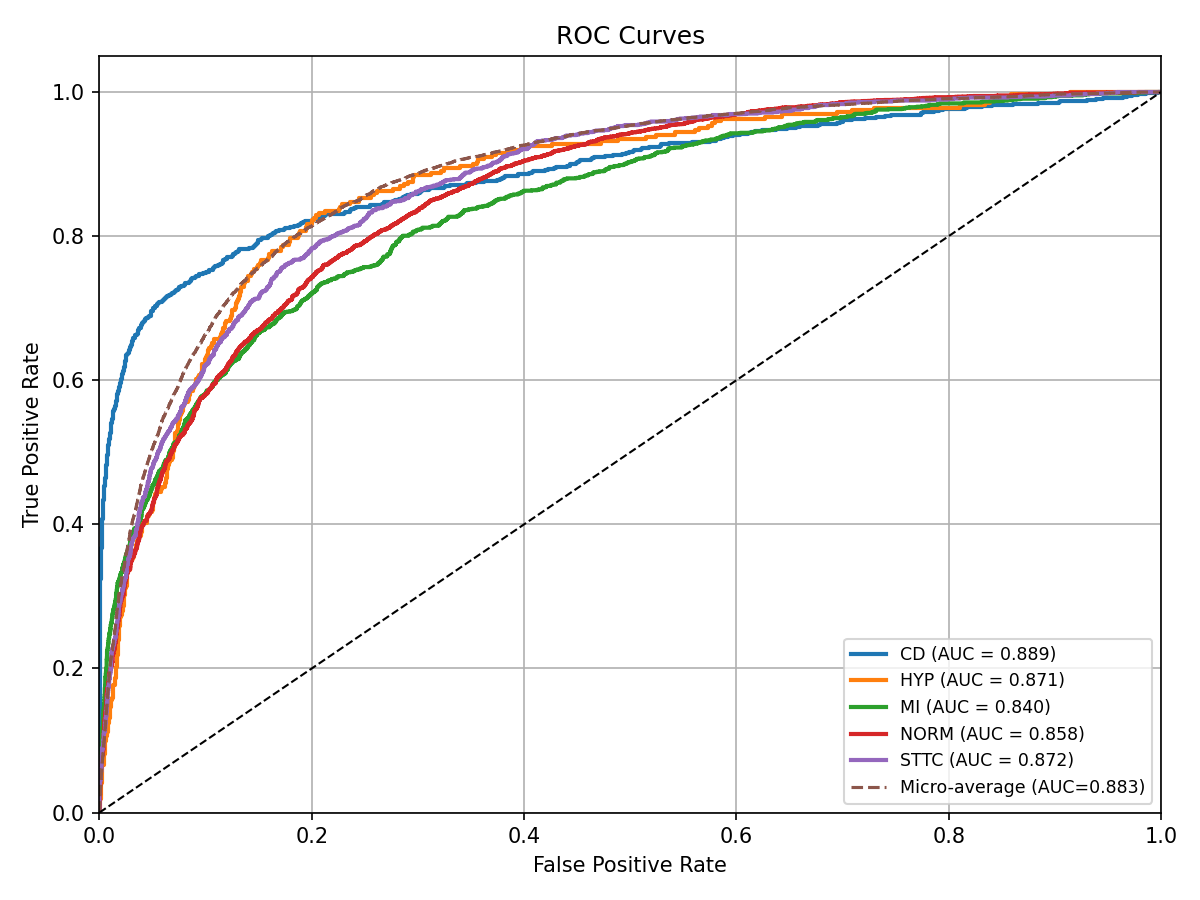


=== 50-50 (50 epochs) ===


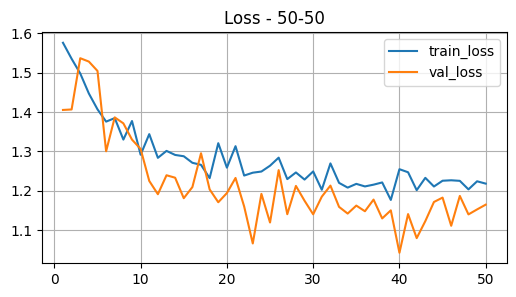

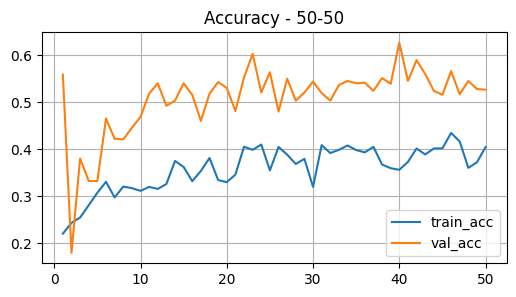

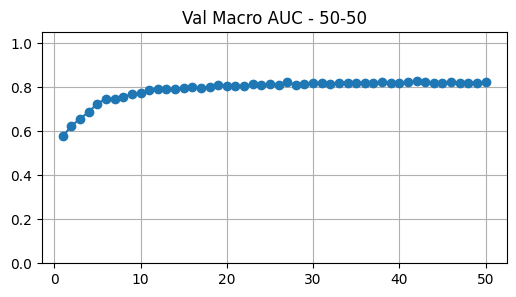

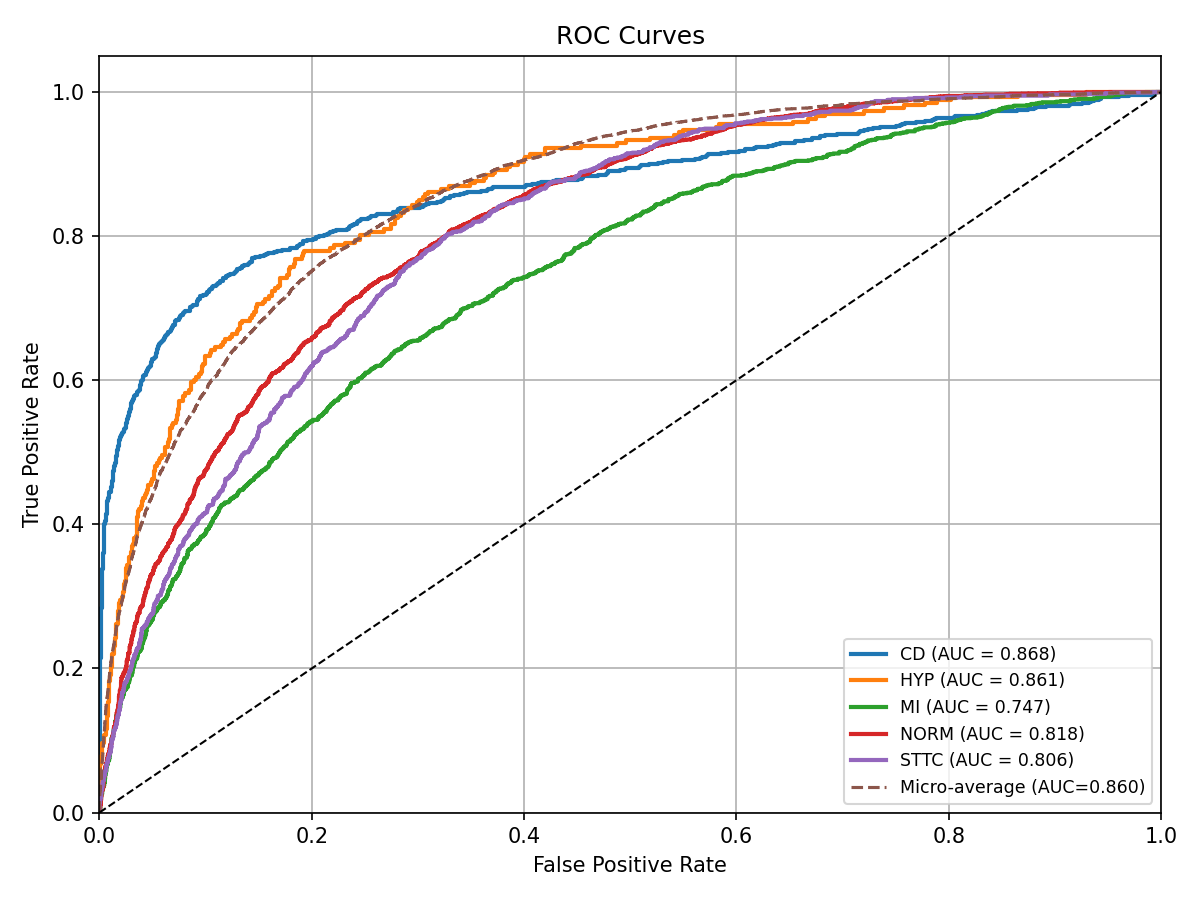


=== 60-40 (50 epochs) ===


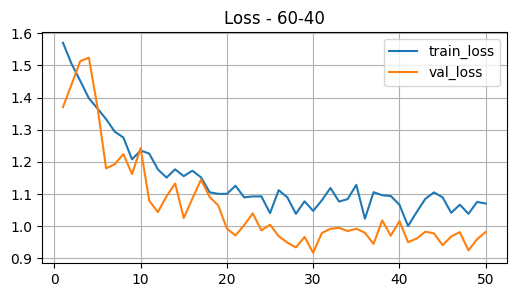

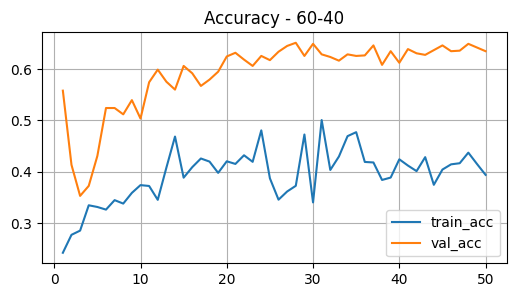

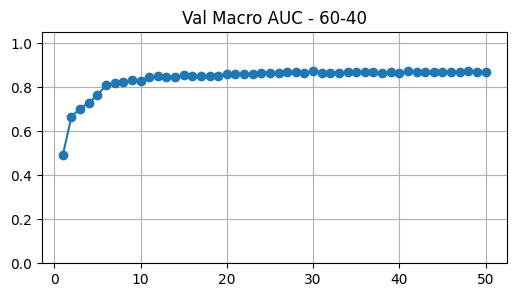

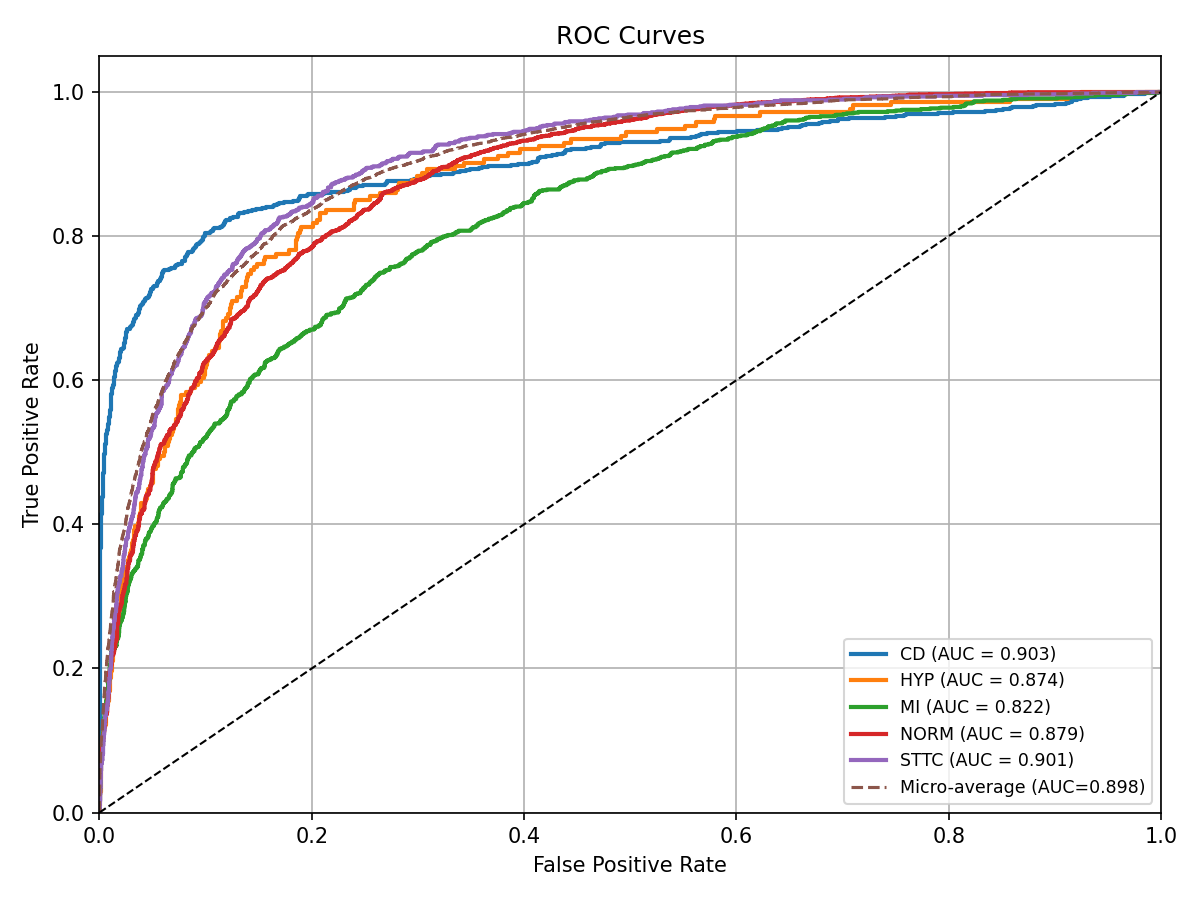


=== 70-30 (50 epochs) ===


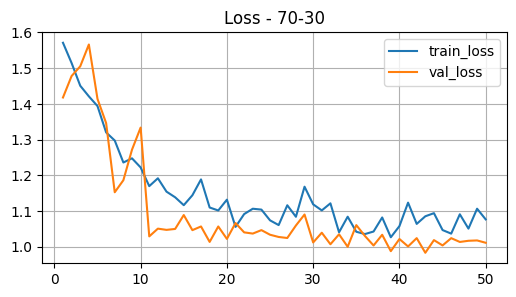

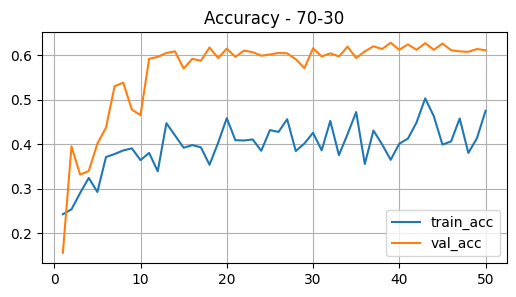

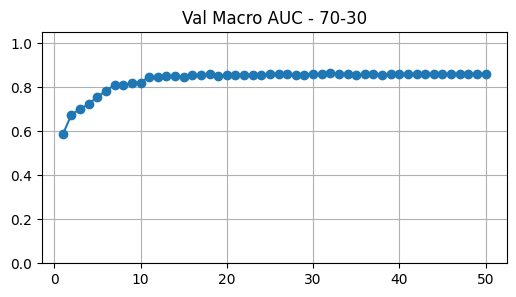

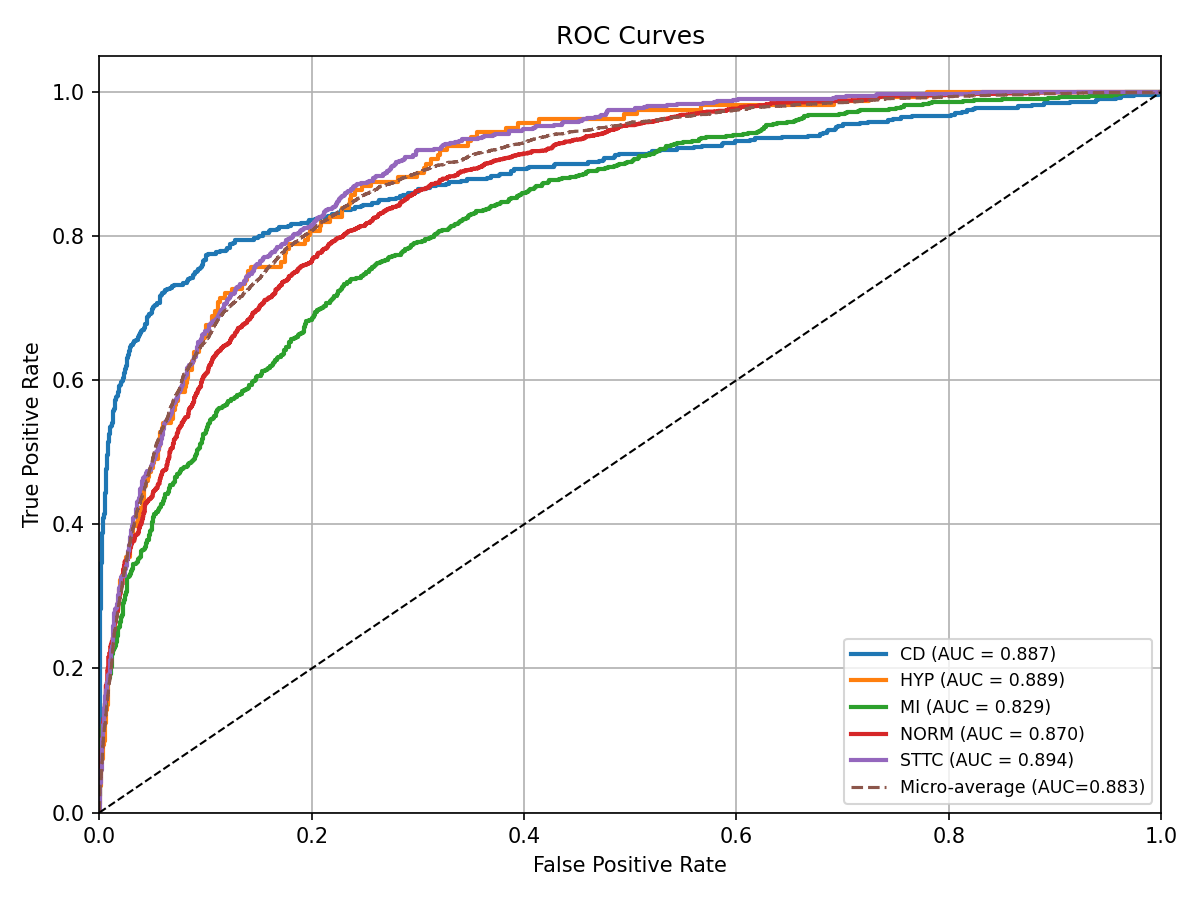


=== 80-20 (50 epochs) ===


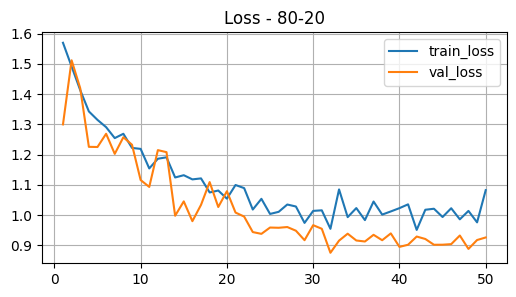

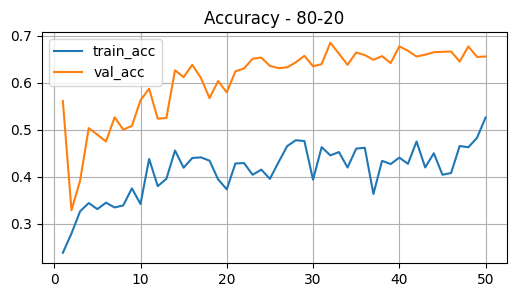

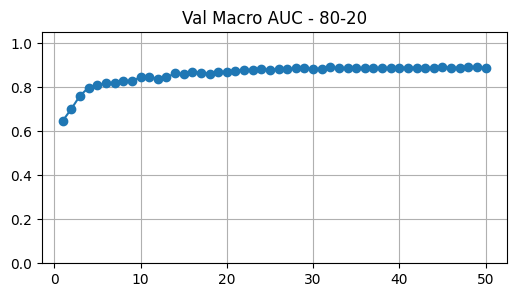

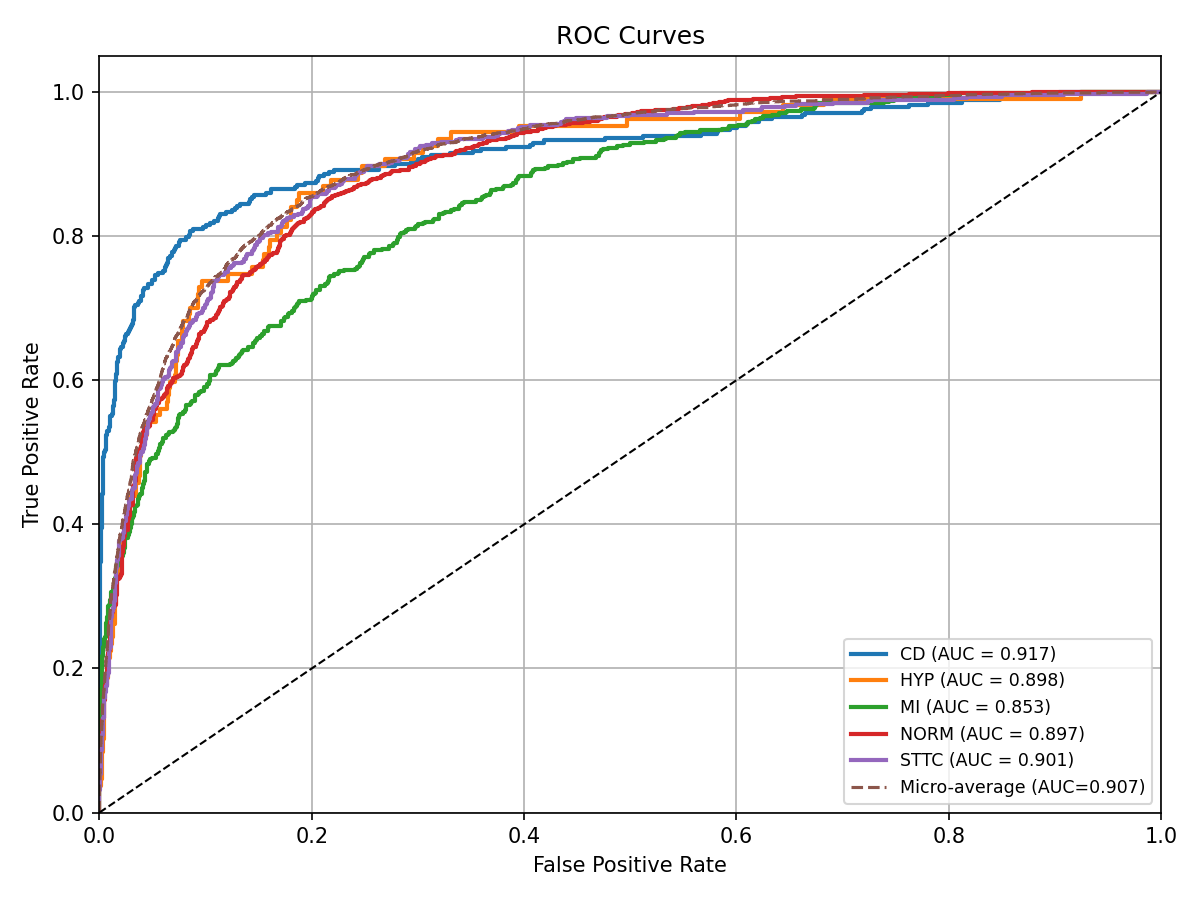


=== 9-90 (50 epochs) ===


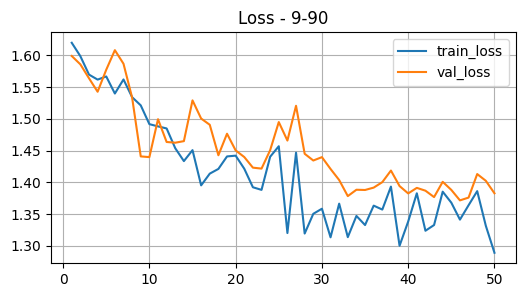

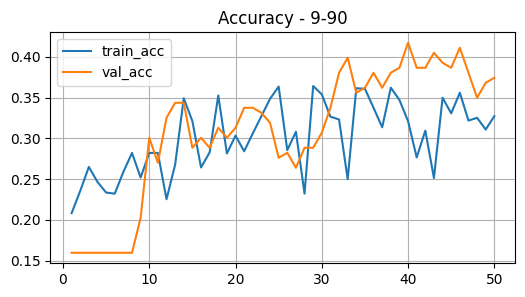

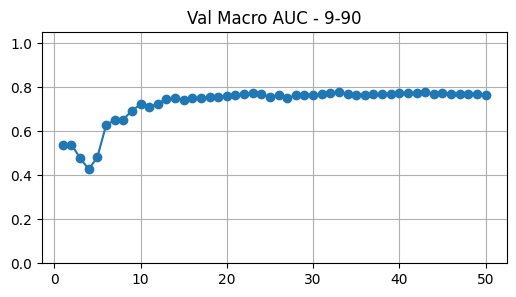

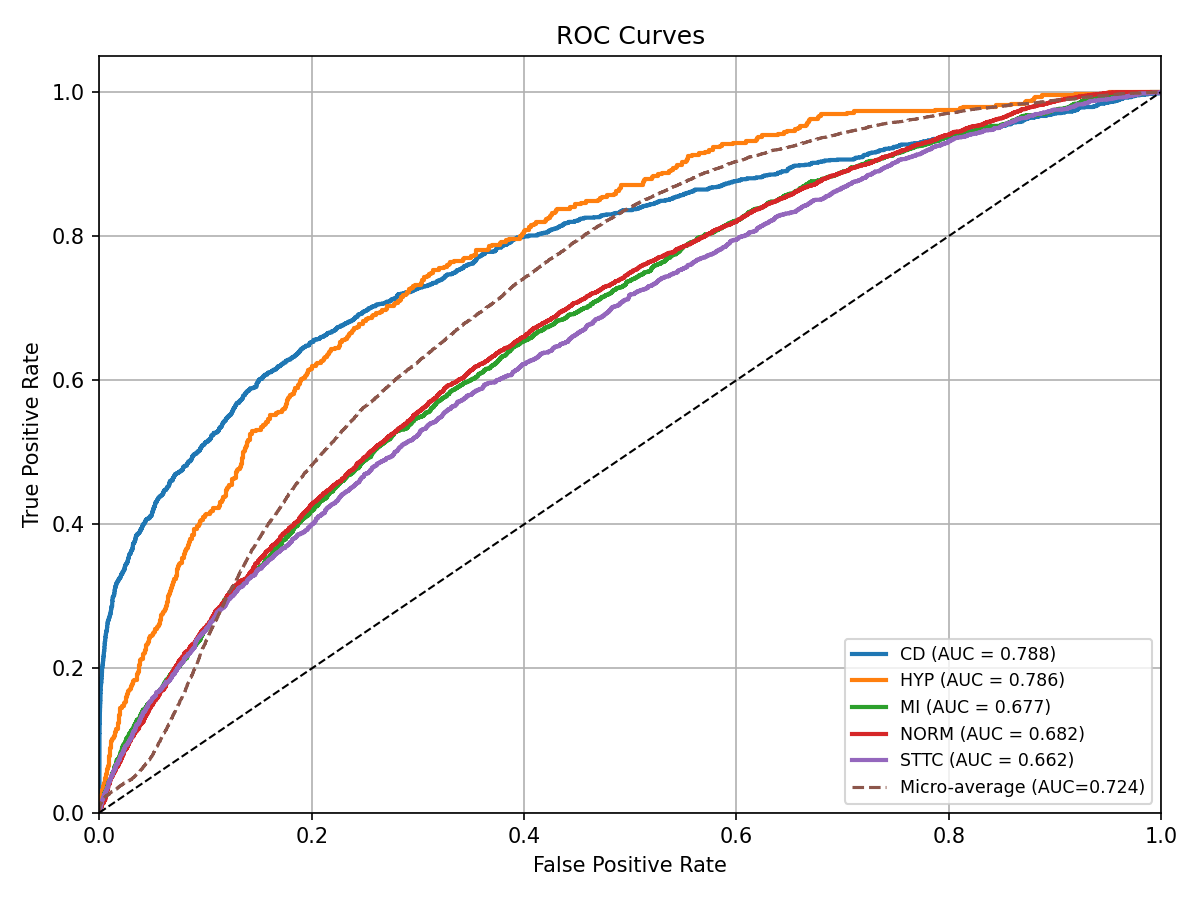


=== 90-10 (50 epochs) ===


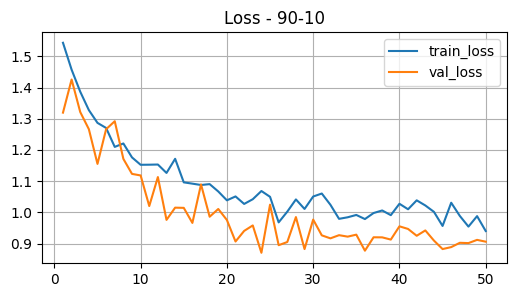

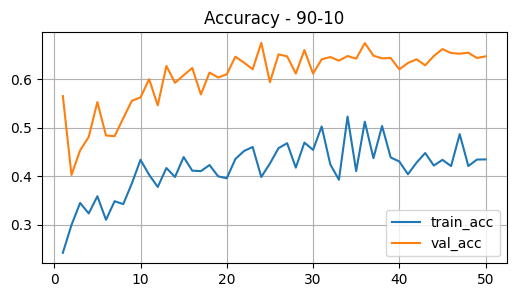

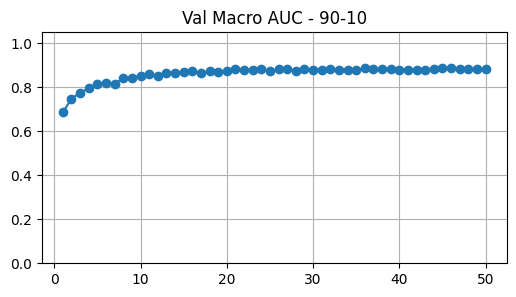

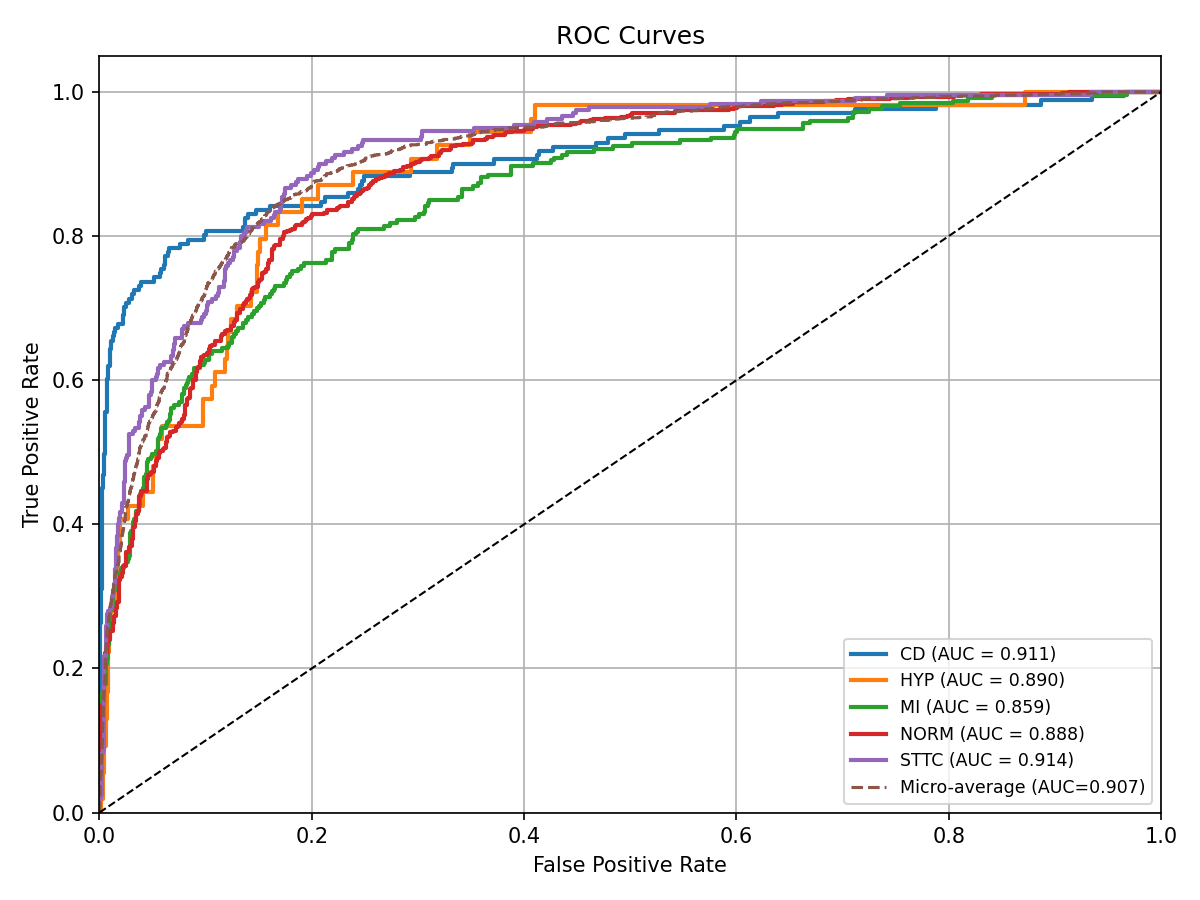

In [6]:
import os, math
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, Image

OUT_DIR = "split_results"
files = sorted([f for f in os.listdir(OUT_DIR) if f.startswith("history_") and f.endswith(".csv")])
if not files:
    print("No history_*.csv files found in", OUT_DIR)
for fname in files:
    split_name = fname.replace("history_","").replace(".csv","")
    path = os.path.join(OUT_DIR, fname)
    df = pd.read_csv(path)
    print(f"\n=== {split_name} ({len(df)} epochs) ===")
    # loss
    plt.figure(figsize=(6,3))
    plt.plot(df['epoch'], df['train_loss'], label='train_loss')
    plt.plot(df['epoch'], df['val_loss'], label='val_loss')
    plt.title(f'Loss - {split_name}'); plt.legend(); plt.grid(True); plt.show()
    # acc
    plt.figure(figsize=(6,3))
    plt.plot(df['epoch'], df['train_acc'], label='train_acc')
    plt.plot(df['epoch'], df['val_acc'], label='val_acc')
    plt.title(f'Accuracy - {split_name}'); plt.legend(); plt.grid(True); plt.show()
    # auc
    if 'val_macro_auc' in df.columns:
        val_aucs = df['val_macro_auc'].tolist()
        val_aucs = [float(x) if (not (isinstance(x, str) and x.lower()=='nan')) else float('nan') for x in val_aucs]
        plt.figure(figsize=(6,3))
        plt.plot(df['epoch'], val_aucs, marker='o', label='val_macro_auc')
        plt.title(f'Val Macro AUC - {split_name}'); plt.ylim(0,1.05); plt.grid(True); plt.show()
    # show ROC image if present
    roc_img = os.path.join(OUT_DIR, f"roc_curves_{split_name}.png")
    if os.path.exists(roc_img):
        display(Image(roc_img))
    else:
        print("No ROC image for", split_name)